In [17]:
import gymnasium as gym
import numpy as np
import os
import csv
import torch
import sardine
import re
import argparse
import datetime
from agents.wrappers import IdealState
from pymoo.indicators.hv import HV
from distutils.util import strtobool

In [18]:
def parse_args():
    parser = argparse.ArgumentParser(description="Environment Evaluation")
    parser.add_argument("--morl", type=lambda x: bool(strtobool(x)), default=False, help="Specify if the algorithm is multi-objective.")
    parser.add_argument("--env-ids", type=str, nargs='+', default=["sardine/SlateTopK-Bored-v0"], help="List of environment IDs.")
    parser.add_argument("--methods", type=str, nargs='+', default=["random"], help="List of methods to evaluate.")
    parser.add_argument("--seeds", type=int, nargs='+', default=[2705, 3751, 4685, 3688, 6383], help="List of seeds for reproducibility.")
    parser.add_argument("--n-val-episodes", type=int, default=200, help="Number of validation episodes.")
    parser.add_argument("--total-timesteps", type=int, default=10000, help="Total timesteps for the evaluation.")
    parser.add_argument("--val-interval", type=int, default=100, help="Interval between validation steps.")
    parser.add_argument("--log-dir", type=str, default="logs", help="Directory to save logs.")
    parser.add_argument("--slate-size", type=int, default=10, help="Size of the slate.")
    
    return parser.parse_args()

# create a dict with parse args stored in a dict

args_dict = {"morl": False, "env-ids": ["sardine/SlateTopK-Bored-v0"], "methods": ["random","greedyoracle"], "seeds": [2705, 3751, 4685, 3688, 6383], "n-val-episodes": 25, "total-timesteps": 10000, "val-interval": 100, "log-dir": "logs", "slate-size": 10}

def log_data(method, steps, returns, log_dir):
    """
    Logs the method returns data into a CSV file.
    """
    os.makedirs(log_dir, exist_ok=True)
    filename = os.path.join(log_dir, f"{method}_returns.csv")
    
    with open(filename, "w", newline="") as csvfile:
        csvwriter = csv.writer(csvfile)
        # Writing header
        csvwriter.writerow(["steps", "return"])
        # Writing data
        for step, ret in zip(steps, returns):
            csvwriter.writerow([step, ret])

In [27]:
start = datetime.datetime.now()


slate_list = [3]
num_items = [100]
num_dict = {}
for num_item in num_items:
    slate_dict = {}
    for slate_size in slate_list:
        for env_id in args_dict["env-ids"]:
            # Make the environment
            env_embedds = None
            env = gym.make(env_id, slate_size=slate_size, morl=args_dict["morl"], num_items = num_item, env_embedds=f"item_embeddings_numitems{num_item}.npy")
            env_name = "-".join(env_id.lower().split("-")[:-1])

            env_dict = {}
            for method in args_dict["methods"]:
                print(f"\nRunning {method} on {env_id} with {num_item} items and slate size {slate_size}")

                click_list = []
                diversity_list = []
                hypervolume_list = []
                catalog_coverage_list = []  # New list to track catalog coverage
                num_users = 0
                val_returns_all = []
                seed_dict = {}

                methods_dict = {}
                for seed in args_dict["seeds"]:
                    info_dict = {}
                    # CSV logger
                    csv_filename = f"run_{env_name}-{method}-0-{seed}"
                    csv_filename = re.sub(r"[^a-zA-Z0-9]+", '-', csv_filename)
                    csv_path = os.path.join(args_dict["log-dir"], "baselines", csv_filename + ".log")
                    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
                    csv_file = open(csv_path, "w+", newline="")
                    csv_writer = csv.writer(csv_file)
                    csv_writer.writerow(["field", "value", "step"])

                    # Environment initialization
                    observation, info = env.reset(seed=seed)
                    env.action_space.seed(seed)

                    # Run the agent on the environment
                    val_returns, val_diversity, val_catalog_coverage = [], [], []
                    seed_clicks = []
                    seed_catalog_coverage = []
                    
                    val_metrics = []
                    for _ in range(args_dict["n-val-episodes"]):
                        cum_reward = 0
                        cum_boredom = 0
                        terminated, truncated = False, False
                        num_users += 1
                        diversity = 0

                        val_reward_list = []
                        catalog_coverage = []
                        val_diversity_list = []
                        while not (terminated or truncated):
                            action = None

                            if method == "greedyoracle":  # Greedy oracle
                                action = -np.ones(env.unwrapped.slate_size, dtype=int)
                            elif method == "random":  # Random slate
                                action = torch.randint(low=0, high=env.unwrapped.num_items, size=(env.unwrapped.slate_size,)).numpy()
                            else: 
                                raise ValueError(f"Unknown method: {method}")
                            observation, reward, terminated, truncated, info = env.step(action)
                            cum_reward += reward
                            cum_boredom += (1.0 if np.sum(info.get("bored", False)) > 0 else 0.0)
                            diversity += info["diversity"]

                            val_reward_list.append(reward)
                            val_diversity_list.append(info["diversity"])
                            catalog_coverage.append(info["catalog_coverage"])  # Track catalog coverage

                            if terminated or truncated:
                                val_metrics.append({"clicks": val_reward_list, "diversity": val_diversity_list, "catalog_coverage": catalog_coverage})  # Store the episode metrics
                                observation, info = env.reset()

                        val_returns.append(cum_reward)
                        seed_clicks.append(cum_reward)
                        seed_catalog_coverage.append(catalog_coverage[-1])  # Store the last catalog coverage value for this episode
                        if args_dict["morl"]:
                            val_diversity.append(cum_reward[1])
                        else:
                            val_diversity.append(diversity / env.unwrapped.H)
                        val_catalog_coverage.append(np.mean(catalog_coverage))  # Store average catalog coverage per episode

                    seed_dict[seed] = val_metrics
                    click_list.append(seed_clicks)
                    catalog_coverage_list.append(seed_catalog_coverage)  # Add catalog coverage to the list
                    
                    if args_dict["morl"]:
                        hypervolume_list.append(HV(ref_point=np.array([0.0, 0.0]) * -1)(val_returns * -1))

                    diversity_list.append(val_diversity)
                    val_returns_all += val_returns

                    # Log the results (including catalog coverage)

                    for i in range(args_dict["total-timesteps"] // args_dict["val-interval"] + 1):
                        global_step = i * args_dict["val-interval"]  # Simulate a global step as in trained agents for plotting purposes
                        csv_writer.writerow(["val_charts/episodic_return", np.mean(val_returns, axis=0), global_step])
                        csv_writer.writerow(["val_charts/diversity", np.mean(val_diversity), global_step])
                        csv_writer.writerow(["val_charts/catalog_coverage", np.mean(val_catalog_coverage), global_step])  # New log for catalog coverage

                    print(f"{method} -- {seed} -- summary: cum_reward = {np.mean(val_returns, axis=0)}, diversity = {np.mean(val_diversity)}, catalog_coverage = {np.mean(val_catalog_coverage)}")
                    info_dict["clicks"]=val_returns
                    info_dict["diversity"]=val_diversity
                    info_dict["catalog_coverage"]=val_catalog_coverage
        
                mean_click_list = np.mean(np.array(click_list), axis=1)
                mean_diversity_list = np.mean(np.array(diversity_list), axis=1)
                mean_catalog_coverage_list = np.mean(np.array(catalog_coverage_list), axis=1)  # Mean catalog coverage
                print(f"Mean click list: {np.mean(mean_click_list)}+-{np.std(mean_click_list)}")
                print(f"Mean diversity list: {np.mean(mean_diversity_list)}+-{np.std(mean_diversity_list)}")
                print(f"Mean catalog coverage: {np.mean(mean_catalog_coverage_list)}+-{np.std(mean_catalog_coverage_list)}")  # New print for catalog coverage

                methods_dict["clicks"] = {"value":np.mean(mean_click_list), "std":np.std(mean_click_list)}
                methods_dict["diversity"] = {"value":np.mean(mean_diversity_list), "std":np.std(mean_diversity_list)}
                methods_dict["catalog_coverage"] = {"value":np.mean(mean_catalog_coverage_list), "std":np.std(mean_catalog_coverage_list)}  # New log for catalog coverage
            


                if args_dict["morl"]:
                    print(f"Mean hypervolume: {np.mean(hypervolume_list)}+-{np.std(hypervolume_list)}")
                env_dict[method] = methods_dict  
            env.close()
        slate_dict[slate_size] = env_dict
        
    num_dict[num_item] = slate_dict


print(num_dict)  
end = datetime.datetime.now()

print("Time taken: ", end - start)
print(f"Number of users: {num_users}")


Running random on sardine/SlateTopK-Bored-v0 with 100 items and slate size 3
random -- 2705 -- summary: cum_reward = 22.0, diversity = 0.2173266666666665, catalog_coverage = 0.689088
random -- 3751 -- summary: cum_reward = 23.16, diversity = 0.21633999999999992, catalog_coverage = 0.694436
random -- 4685 -- summary: cum_reward = 21.04, diversity = 0.21714666666666654, catalog_coverage = 0.683692
random -- 3688 -- summary: cum_reward = 21.68, diversity = 0.21706666666666657, catalog_coverage = 0.6919119999999999
random -- 6383 -- summary: cum_reward = 23.32, diversity = 0.21706666666666657, catalog_coverage = 0.6893560000000001
Mean click list: 22.24+-0.8745284443630182
Mean diversity list: 0.2169893333333332+-0.00033827273677378904
Mean catalog coverage: 0.94776+-0.002880000000000059

Running greedyoracle on sardine/SlateTopK-Bored-v0 with 100 items and slate size 3
greedyoracle -- 2705 -- summary: cum_reward = 109.68, diversity = 0.18321333333333342, catalog_coverage = 0.056715999999

In [28]:
import pandas

# create dataframe out of the dictionary. Create it so that a row has the following columns: num_items, slate_size, method, clicks, diversity, catalog_coverage

df = pandas.DataFrame(columns=["num_items", "slate_size", "method", "clicks", "diversity", "catalog_coverage"])

row_list = []
for num_items, slate_dict in num_dict.items():
    for slate_size, env_dict in slate_dict.items():
        for method, methods_dict in env_dict.items():
            # append row to the dataframe
            row_list.append([num_items, slate_size, method, methods_dict["clicks"]["value"], methods_dict["clicks"]["std"], methods_dict["diversity"]["value"], methods_dict["diversity"]["std"], methods_dict["catalog_coverage"]["value"], methods_dict["catalog_coverage"]["std"]])

df = pandas.DataFrame(row_list, columns=["num_items", "slate_size", "method", "clicks", "clicks (std)" ,"diversity", "diversity (std)", "catalog_coverage", "catalog_coverage (std)"])

df.sort_values(["method", "slate_size", "num_items"], inplace=True)


In [29]:
save = False:

if save:
    df.to_excel("baselines_results.xlsx", index=False)

SyntaxError: invalid syntax (3452534923.py, line 1)

In [92]:
df["clicks standard error"] = df["clicks (std)"] / np.sqrt(len(args_dict["seeds"]))
df["diversity standard error"] = df["diversity (std)"] / np.sqrt(len(args_dict["seeds"]))
df["catalog_coverage standard error"] = df["catalog_coverage (std)"] / np.sqrt(num_users)
df

,num_items,slate_size,method,clicks,clicks (std),diversity,diversity (std),catalog_coverage,catalog_coverage (std),clicks standard error,diversity standard error,catalog_coverage standard error
1,100,3,greedyoracle,107.512,3.877269,0.180085,0.002996,0.05856,0.001031,1.733967,0.001340,0.000092
0,100,3,random,22.240,0.874528,0.216989,0.000338,0.94776,0.002880,0.391101,0.000151,0.000258


In [116]:
import matplotlib.pyplot as plt
import numpy as np
import os

def make_plot(slate_size, num_items, metric, file_path, env_id, show=False, baseline_dict=None, test=False, num_steps=500000):
    # Get random agent data
    clicks_random = df[(df["method"] == "random") & (df["slate_size"] == slate_size) & (df["num_items"] == num_items)][metric].values[0]
    clicks_random_err = df[(df["method"] == "random") & (df["slate_size"] == slate_size) & (df["num_items"] == num_items)][f"{metric} standard error"].values[0]

    # Get greedy oracle data
    clicks_greedy = df[(df["method"] == "greedyoracle") & (df["slate_size"] == slate_size) & (df["num_items"] == num_items)][metric].values[0]
    clicks_greedy_err = df[(df["method"] == "greedyoracle") & (df["slate_size"] == slate_size) & (df["num_items"] == num_items)][f"{metric} standard error"].values[0]

    # Create x-axis values
    x = np.linspace(0, num_steps, 100)  # 100 steps from 0 to 500,000

    # Create lines for random and greedy data
    greedy = np.full(len(x), clicks_greedy)  # Constant value for Greedy Oracle
    random = np.full(len(x), clicks_random)  # Random values for Random Agent

    # Error margins for random and greedy
    greedy_err = clicks_greedy_err
    random_err = clicks_random_err

    # Create plot
    size = 8
    plt.figure(figsize=(size, size * 6 / 8))

    # Plot Random Agent
    plt.plot(x, random, label="Random Agent", color="blue")
    plt.fill_between(x, random - clicks_random_err, random + clicks_random_err, alpha=0.3, color="blue")

    # Plot Greedy Oracle
    plt.plot(x, greedy, label="Greedy Oracle", color="orange")
    plt.fill_between(x, greedy - clicks_greedy_err, greedy + clicks_greedy_err, alpha=0.3, color="orange")

    # Generalized plotting for baselines provided in baseline_dict
    if baseline_dict is not None:
        colors = ['green', 'red', 'purple', 'brown', 'cyan']  # Color list for different baselines
        for idx, (baseline_name, data) in enumerate(baseline_dict.items()):
            # Get steps, values, and errors from the baseline data
            baseline_steps = sorted(data.keys())
            baseline_values = [data[step][0] for step in baseline_steps]
            baseline_err = [data[step][1] for step in baseline_steps]

            # Plot the baseline data
            plt.plot(baseline_steps, baseline_values, label=baseline_name, color=colors[idx % len(colors)])
            plt.fill_between(baseline_steps, 
                             np.array(baseline_values) - np.array(baseline_err), 
                             np.array(baseline_values) + np.array(baseline_err), 
                             alpha=0.3, color=colors[idx % len(colors)])

    # Adding labels and title
    ylabel = "val cumulative clicks" if metric == "clicks" else "val intra-list diversity" if metric == "diversity" else "val coverage" if metric == "catalog_coverage" else "val_episodic return"

    plt.xlabel('number of steps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc="best")

    # Save plot in folder
    filename = f"{env_id}_{metric}_slatesize{slate_size}_numitems{num_items}.png"
    if not test:
        plt.savefig(os.path.join(file_path, filename), dpi=400)
    if show:
        plt.show()

    print(f"Plot {filename} saved in folder {file_path} for num items={num_items} and slate size={slate_size}.")



Plot SlateTopK-Bored-v0_clicks_slatesize3_numitems100.png saved in folder plots\slatesize3\numitems100 for num items=100 and slate size=3.


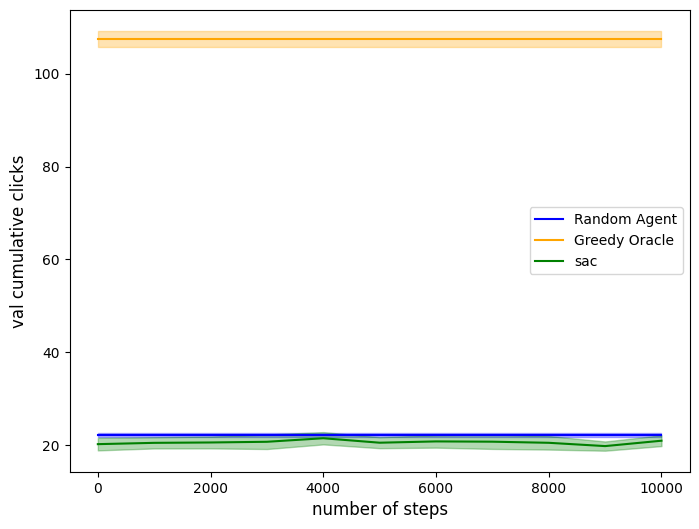

In [117]:

make_plot(3, 100, "clicks", os.path.join("plots","slatesize3","numitems100"), env_id, baseline_dict={"sac": mean_clicks_per_step}, num_steps=10000)


In [43]:
slate_sizes = [3, 5, 10, 20]
num_itemss = [100, 500, 1000]
env_id = "SlateTopK-Bored-v0"

run = False
if run == True:
    os.makedirs("plots", exist_ok=True)
    for slate_size in slate_sizes:
        file_path_slate_size = os.path.join("plots", f"slatesize{slate_size}")
        os.makedirs(file_path_slate_size, exist_ok=True)
        for num_items in num_itemss:
            os.makedirs(os.path.join(file_path_slate_size, f"numitems{num_items}"), exist_ok=True)
            file_path = os.path.join(file_path_slate_size, f"numitems{num_items}")
            make_plot(slate_size, num_items, "clicks", file_path, env_id)
            make_plot(slate_size, num_items, "diversity", file_path, env_id)
            make_plot(slate_size, num_items, "catalog_coverage", file_path, env_id)

In [56]:
import os 

# get all the files in the logs folder
files = os.listdir(os.path.join("logs", "sac"))
# get files that contain the string 'sac-gems-slatesize3-numitems100" 

files = [file for file in files if "sac-gems-slatesize3-num-items100-seed" in file]
print(files)

['sac-gems-slatesize3-num-items100-seed2024-2024-09-27-15-38-14-193984.log', 'sac-gems-slatesize3-num-items100-seed2025-2024-09-27-15-39-53-776600.log', 'sac-gems-slatesize3-num-items100-seed2026-2024-09-27-15-41-30-777937.log', 'sac-gems-slatesize3-num-items100-seed2027-2024-09-27-15-42-59-234369.log', 'sac-gems-slatesize3-num-items100-seed2028-2024-09-27-15-45-08-784849.log']


In [72]:
import re


file_path = "logs/sac-gems-slatesize3-num-items100-seed2024-2024-09-27-15-07-52-185995.log"

sac_runs = []
for file_path in files:
    # Initialize an empty dictionary to hold step data
    step_data = {}

    # Open the file and read line by line
    with open(os.path.join("logs", "sac", file_path), 'r') as file:
        for line in file:
            # Using regex to find lines that contain step data (assuming format: "Step X: ...")
            step_match = re.match(r'Step (\d+):\s*(.*)', line)
            
            if step_match:
                step_num = int(step_match.group(1))  # Step number
                data = step_match.group(2)  # Data associated with the step
                step_data[step_num*100] = data  # Add to the dictionary

    subdivided_data = {}

    for step, data in step_data.items():
        # Split the data by commas and then further split by '=' to create key-value pairs
        data_items = [item.split('=') for item in data.split(', ')]
        
        # Create a dictionary for the subdivided data for this step
        step_dict = {key.strip(): float(value.strip()) for key, value in data_items}
        
        # Add the subdivided data to the main dictionary
        subdivided_data[step] = step_dict

    subdivided_data

    baseline_dict = []
    baseline_dict.append(subdivided_data)
    sac_runs.append(subdivided_data)

print(len(sac_runs))


5


In [113]:
from collections import defaultdict
import numpy as np

# Dictionary to collect the clicks, diversity, and catalog_coverage per step
metrics_dict = defaultdict(lambda: {'clicks': [], 'diversity': [], 'catalog_coverage': []})

# Iterate over each run
for run in sac_runs:
    for step, run_info in run.items():
        # Append data to the respective metric lists
        metrics_dict[step]['clicks'].append(run_info['clicks'])
        metrics_dict[step]['diversity'].append(run_info['diversity'])
        metrics_dict[step]['catalog_coverage'].append(run_info['catalog coverage'])

# Now calculate the mean and standard error for each metric at each step
mean_metrics_per_step = {
    step: {
        'clicks': (np.mean(metrics['clicks']), np.std(metrics['clicks']) / np.sqrt(len(metrics['clicks']))),
        'diversity': (np.mean(metrics['diversity']), np.std(metrics['diversity']) / np.sqrt(len(metrics['diversity']))),
        'catalog_coverage': (np.mean(metrics['catalog_coverage']), np.std(metrics['catalog_coverage']) / np.sqrt(len(metrics['catalog_coverage'])))
    }
    for step, metrics in metrics_dict.items()
}

print(mean_metrics_per_step)



{0: {'clicks': (20.21, 1.3500666650206572), 'diversity': (0.21400000000000002, 0.002190890230020666), 'catalog_coverage': (0.06, 0.0)}, 1000: {'clicks': (20.49, 1.2049398325227694), 'diversity': (0.21800000000000003, 0.0017888543819998333), 'catalog_coverage': (0.06, 0.0)}, 2000: {'clicks': (20.57, 1.274174242401721), 'diversity': (0.21600000000000003, 0.004560701700396552), 'catalog_coverage': (0.06, 0.0)}, 3000: {'clicks': (20.72, 1.5638797907767716), 'diversity': (0.21600000000000003, 0.003577708763999661), 'catalog_coverage': (0.06, 0.0)}, 4000: {'clicks': (21.479999999999997, 1.326996608887905), 'diversity': (0.22000000000000003, 0.0028284271247461922), 'catalog_coverage': (0.06, 0.0)}, 5000: {'clicks': (20.52, 1.1829285692720422), 'diversity': (0.21600000000000003, 0.002190890230020666), 'catalog_coverage': (0.06, 0.0)}, 6000: {'clicks': (20.8, 1.3430562162471085), 'diversity': (0.21200000000000002, 0.0033466401061363013), 'catalog_coverage': (0.06, 0.0)}, 7000: {'clicks': (20.74

In [ ]:
baseline_dict["sac"]

{0: {'clicks': 26.15,
  'clicks_se': 5.85,
  'diversity': 0.22,
  'diversity_se': 0.0488208175087454,
  'catalog coverage': 0.06,
  'catalog coverage_se': 0.0},
 1000: {'clicks': 25.5,
  'clicks_se': 5.7,
  'diversity': 0.22,
  'diversity_se': 0.04844813951249545,
  'catalog coverage': 0.06,
  'catalog coverage_se': 0.0},
 2000: {'clicks': 21.05,
  'clicks_se': 4.71,
  'diversity': 0.22,
  'diversity_se': 0.0499388514974953,
  'catalog coverage': 0.08,
  'catalog coverage_se': 0.0},
 3000: {'clicks': 19.35,
  'clicks_se': 4.33,
  'diversity': 0.21,
  'diversity_se': 0.047889122518120504,
  'catalog coverage': 0.08,
  'catalog coverage_se': 0.0},
 4000: {'clicks': 29.1,
  'clicks_se': 6.51,
  'diversity': 0.23,
  'diversity_se': 0.05068420748999524,
  'catalog coverage': 0.07,
  'catalog coverage_se': 0.0},
 5000: {'clicks': 19.85,
  'clicks_se': 4.44,
  'diversity': 0.22,
  'diversity_se': 0.048075461516245484,
  'catalog coverage': 0.07,
  'catalog coverage_se': 0.0},
 6000: {'clicks'